## Fine-tuning Stable Diffusion XL with DreamBooth and LoRAs

(_NOTE_: Notebook repurposed from Diffusers Github - IS)

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) on an a10g GPU.

SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous variants.

So, to pull this off, we will make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. So, hang tight and let's get started 🧪

## Setup 🪓

In [1]:
# Check the GPU
!nvidia-smi

Sun Oct 15 22:06:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1C.0 Off |                    0 |
|  0%   18C    P8    10W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install dependencies.
#!yes | pip uninstall pillow scipy torch xformers bitsandbytes transformers accelerate pillow torch
#!pip install pillow scipy torch xformers bitsandbytes transformers accelerate pillow torch -q

Make sure to install `diffusers` from `main`.

In [1]:
# PR Open for Type Mismatch: https://github.com/huggingface/diffusers/issues/5368 (IS)
# Rollback -b v0.21.4 (IS)
!pip install git+https://github.com/huggingface/diffusers.git@v0.21.4  

  Cloning https://github.com/huggingface/diffusers.git (to revision v0.21.4) to /tmp/pip-req-build-iyfoevrl
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-iyfoevrl
  Running command git checkout -q 805689aa52932192e8396c984b6b82abab2d77fc
  Resolved https://github.com/huggingface/diffusers.git to commit 805689aa52932192e8396c984b6b82abab2d77fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download `diffusers` SDXL DreamBooth training script.

In [12]:
# Rollback to previous version of diffuser utility script (IS)
!wget https://raw.githubusercontent.com/huggingface/diffusers/v0.21.4-patch/examples/dreambooth/train_dreambooth_lora_sdxl.py


--2023-10-15 22:15:00--  https://raw.githubusercontent.com/huggingface/diffusers/v0.21.4-patch/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57654 (56K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  56.30K  --.-KB/s    in 0.002s  

2023-10-15 22:15:00 (24.9 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [57654/57654]



## Dataset 🐶

Let's download some example images:

In [3]:
from huggingface_hub import snapshot_download

local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 61.61it/s]


'/home/jovyan/dog'

In [ ]:
! mkdir trainers
! wget -P trainers https://cdn-images.farfetch-contents.com/20/67/39/60/20673960_50561608_1000.jpg
! wget -P trainers https://cdn-images.farfetch-contents.com/20/67/39/60/20673960_50561606_1000.jpg
! wget -P trainers https://cdn-images.farfetch-contents.com/20/67/39/60/20673960_50561617_1000.jpg
! wget -P trainers https://cdn-images.farfetch-contents.com/20/67/39/60/20673960_50561618_1000.jpg
! wget -P trainers https://cdn-images.farfetch-contents.com/20/67/39/60/20673960_50561602_1000.jpg


Preview the images:

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

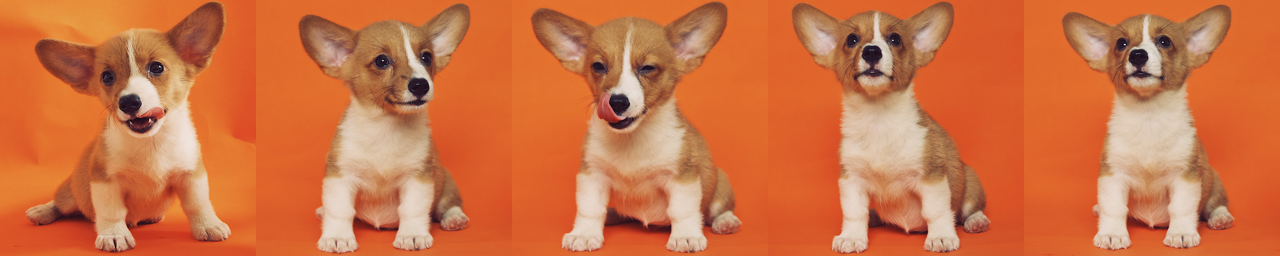

In [5]:
import glob

imgs = [Image.open(path) for path in glob.glob("./dog/*.jpeg")]
image_grid(imgs, 1, 5)

## Prep for training 💻

Initialize `accelerate`:

In [6]:
!accelerate config default

Configuration already exists at /home/jovyan/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


# Optional - push checkpoints to HF account
Make sure to log into [your Hugging Face account](https://huggingface.co/) and pass [your access token](https://huggingface.co/docs/hub/security-tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [7]:
#!echo "hf_TOKEN" | huggingface-cli login

## Train! 🔬

Alright let's launch a training. Make sure to add `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost.

To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* Memory-efficient attention (`--enable_xformers_memory_efficient_attention`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

In [13]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="dog" \
  --output_dir="lora-trained-xl-colab" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of sks dog" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --enable_xformers_memory_efficient_attention \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"
  ## --push_to_hub

/opt/conda/lib/python3.11/site-packages/accelerate/accelerator.py:382: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
10/15/2023 22:15:12 - INFO - __main__ - Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'clip_sample_range', 'dynamic_thresholding_ratio', 'thresholding', 'variance_type'} was not found in config. Values will be initialized to default values.
{'attention_type', 'dropout'} was not found in config. Values will be initia

Cool the model has been uploaded to https://huggingface.co/sayakpaul/lora-trained-xl-colab 🔥🚀

Let's generate some images with it!

## Inference 🐕

In [14]:
from diffusers import DiffusionPipeline
import torch

from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae, torch_dtype=torch.float16, variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("sayakpaul/lora-trained-xl-colab")

_ = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.41it/s]


In [ ]:
prompt = "a photo of sks dog in a bucket"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image